## 🧭 B. Purpose of the Data Analysis

### 1️⃣ Research Question

The dataset represents residential property data and is analyzed from the perspective of a **real estate agent** seeking to determine accurate listing prices for homes.

**Research Question:**  
> *Which of a home’s attributes affect the sale price the most, and by how much?*

This question is critical for real estate professionals who want to understand the key drivers of home value.  
By using **multiple linear regression (MLR)**, we can measure the individual impact of each variable — such as square footage, number of bedrooms, property age, and proximity to amenities — on the final sale price, while controlling for all other factors.  

The output will not only quantify how much each feature contributes to price but also reveal which factors have the **strongest influence** on valuation.

---

### 2️⃣ Goal of the Analysis

**Goal:**  
> To develop a reusable, data-driven regression model that predicts a home’s sale price based on its characteristics and surrounding conditions.

This analysis aims to provide real estate agents with a **predictive tool** that can:
- Estimate fair asking prices for new listings.  
- Identify which property features add or detract the most value.  
- Be updated regularly as new housing data becomes available, ensuring ongoing accuracy and adaptability to market trends.

The goal is both **realistic and actionable** within the dataset’s scope.  
Key variables such as `SquareFootage`, `NumBathrooms`, `NumBedrooms`, `AgeOfHome`, `EmploymentRate`, and `RenovationQuality` provide a strong foundation for building and validating a multiple linear regression model that supports real-world pricing decisions.

---

### 💡 Why This Matters

In a competitive housing market, pricing a property too high can lead to extended time on the market, while pricing too low results in lost revenue.  
A well-built regression model allows agents to make **data-backed pricing decisions**, improving both client trust and business outcomes.

---



## 🧹 C. Data Preparation

### 1️⃣ Identifying Dependent and Independent Variables

**Dependent Variable (Target):**
- `Price` – the home’s final sale price, which we aim to predict.

**Independent Variables (Predictors):**
The predictors were selected based on their logical and measurable relationship to home value. Each represents either a **physical attribute** of the property or a **contextual factor** that influences pricing.

| Type | Variable | Description | Justification |
|------|-----------|--------------|----------------|
| Physical | `SquareFootage` | Total interior living space | Larger homes generally command higher prices. |
| Physical | `NumBathrooms` | Number of bathrooms | More bathrooms increase convenience and home value. |
| Physical | `NumBedrooms` | Number of bedrooms | More bedrooms increase utility and resale potential. |
| Physical | `BackyardSpace` | Outdoor living area | Outdoor amenities can increase property value. |
| Age/Condition | `AgeOfHome` | Age of the property | Newer homes often sell for more; older homes may depreciate. |
| Location | `DistanceToCityCenter` | Distance from urban hub | Homes closer to city centers typically have higher prices. |
| Economic | `EmploymentRate` | Local employment percentage | Strong local economies can support higher home values. |
| Fiscal | `PropertyTaxRate` | Local property tax rate | May influence affordability and demand. |
| Quality | `RenovationQuality` | Quality score of renovations | Better renovations raise desirability and price. |
| Amenities | `LocalAmenities` | Nearby services (e.g., schools, shops) | More amenities often increase value. |
| Accessibility | `TransportAccess` | Transportation convenience | Good transport access can drive higher demand. |
| Binary (Feature) | `Fireplace` | Whether the home has a fireplace | Premium feature, increases comfort/value. |
| Binary (Feature) | `Garage` | Whether the home has a garage | Functional amenity valued by buyers. |
| Categorical | `HouseColor` | Exterior color | May affect curb appeal (to be encoded as dummy variables). |

**Excluded Variables:**
- `ID`: Identifier, no predictive meaning.
- `PreviousSalePrice`: Represents past pricing, which could cause data leakage.
- `IsLuxury`: Likely derived from other attributes (e.g., square footage, amenities).

---

**Justification Summary:**
These predictors were selected because they reflect *actionable*, *interpretable*, and *measurable* factors that influence property prices. They align with the research question’s goal: identifying which attributes most strongly affect sale price and quantifying their impact.


### 🧾 C2 Extended – Descriptive Statistics with Data Quality Checks

To better understand the dataset and ensure data integrity, descriptive statistics were computed for all numerical variables, along with checks for missing, zero, negative, and extreme (outlier) values.

| Metric | Description |
|---------|-------------|
| **Count, Mean, Std, Min, Max** | Standard descriptive statistics summarizing variable distribution. |
| **Zeros** | Number of zero values, indicating potential missing proxies. |
| **Negatives** | Invalid entries for variables that cannot be negative (e.g., Price, SquareFootage). |
| **Nulls** | Missing values requiring imputation or exclusion. |
| **Outliers (|z|>3)** | Observations exceeding ±3 standard deviations from the mean. |

These statistics help identify inconsistencies before model building and guide decisions on cleaning or transformation.


# IMPORT NECESSARY LIBRARIES

In [4]:
import pandas as pd                                     #data manipulation and analysis (used for handling datasets)
import numpy as np                                      #numerical computing (arrays, math, statistics)
import math                                             #basic math operations and constants

import matplotlib.pyplot as plt                         #visualizations (plots, charts, histograms)
import seaborn as sns                                   #statistical visualizations (pretty plots built on matplotlib)

import statsmodels.api as sm                            #statistical modeling library (used for linear regression + summaries)
from sklearn.model_selection import train_test_split    #split dataset into training and testing subsets
from sklearn.metrics import mean_squared_error          #evaluate regression model accuracy (MSE metric)
from statsmodels.stats.outliers_influence import variance_inflation_factor  #collinearity checks
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan

# GLOBAL SETTINGS

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# HELPER FUNCTIONS

### DESCRIPTIVE STATS HELPER FUNCTION

In [6]:
def describe_full_styled(df):
 
    #Generate a detailed, styled summary of a DataFrame.

    #Parameters:
        #df (pandas.DataFrame)

    #Returns:
        #none

    #Initialize an empty list to collect summary rows
    rows = []

    #iterate over each column name in the DataFrame
    for col in df.columns:
        
        series = df[col]                               #extract the Series (a single column from pandas)
        dtype = str(series.dtypes)                     #get data type of the Series as string (e.g., 'int64', 'object')
        
        #determine the analytical type (numeric, binary, categorical)
        if np.issubdtype(series.dtype, np.number):     #numpy function checks if numeric
            analytical_type = "Numeric"
        elif series.dtype == "bool":                   #boolean columns are binary
            analytical_type = "Binary"
        else:                                          #everything else treated as categorical
            analytical_type = "Categorical"            

        #basic column metrics using pandas methods
        count = series.count()            #non-null count (pandas.Series.count)
        unique = series.nunique()         #number of unique values (pandas.Series.nunique)
        nulls = series.isnull().sum()     #number of missing values (pandas.Series.isnull)
        #number of zero values
        zeros = (series == 0).sum() if np.issubdtype(series.dtype, np.number) else np.nan
        #number of negative values
        negatives = (series < 0).sum() if np.issubdtype(series.dtype, np.number) else np.nan

        #initialize default numeric stats as null
        mean = std = minv = maxv = outliers = np.nan
        
        #only compute numeric stats if the column is numeric
        if np.issubdtype(series.dtype, np.number):
            mean = series.mean()     #arithmetic mean (pandas.Series.mean)
            std = series.std()       #standard deviation (pandas.Series.std)
            minv = series.min()      #minimum value (pandas.Series.min)
            maxv = series.max()      #maximum value (pandas.Series.max)
            #compute z-scores manually: (x - mean) / std
            z_scores = (series - mean) / std if std != 0 else pd.Series([0]*len(series))
            #count outliers using the 3-sigma rule (|z| > 3)
            outliers = (abs(z_scores) > 3).sum()

        #append computed metrics for the current column as a dictionary
        rows.append({
            "Variable": col,
            "Storage Type": dtype,
            "Analytical Type": analytical_type,
            "Count": count,
            "Unique": unique,
            "Mean": mean,
            "Std": std,
            "Min": minv,
            "Max": maxv,
            "Zeros": zeros,
            "Negatives": negatives,
            "Nulls": nulls,
            "Outliers(|z|>3)": outliers
        })

    #convert list of dicts into a DataFrame
    df_summary = pd.DataFrame(rows)

    
    #stylish output
    styled = (df_summary.style
        .background_gradient(subset=['Mean', 'Std', 'Max'], cmap='Blues')
        .background_gradient(subset=['Outliers(|z|>3)', 'Nulls'], cmap='Reds')
        .format(precision=2)
        .set_caption("Comprehensive Data Summary")
        .hide(axis="index")
        .set_table_styles([{
            'selector': 'caption',
            'props': [('caption-side', 'top'),
                      ('font-size', '16px'),
                      ('font-weight', 'bold'),
                      ('color', '#333')]
        }])
    )

    #display behavior depends on environment
   
    try:
        #attempt to detect whether we're running inside a Jupyter Notebook
        #IPython.get_ipython() returns the current interactive shell instance.
        from IPython import get_ipython
        ip = get_ipython()

        #if the returned IPython instance has 'IPKernelApp' in its config,
        #that means we are running inside a Jupyter notebook or JupyterLab kernel.
        if ip is not None and 'IPKernelApp' in ip.config:
           
            #CASE 1: Running in Jupyter Notebook/Lab
            #we can display the styled DataFrame inline using IPython.display.display().
            from IPython.display import display
            display(styled)
            
        else:
            #CASE 2: Running as a normal Python script (CLI, VS Code terminal, etc.)
            #in this case, there is no notebook renderer for HTML,
            #so we manually export the styled table as an HTML file
            #and try to open it in a browser window.
            
            #import standard libraries for temp files/dirs, file paths
            #URLS, shell access, I/O
            import tempfile, os, webbrowser, pathlib

            #create a temporary directory and file path
            #tempfile.gettempdir() returns the system’s temp folder (/tmp on Linux, %TEMP% on Windows)
            temp_dir = tempfile.gettempdir()
            temp_path = os.path.join(temp_dir, "describe_full_styled.html")

            #convert the Styler object to HTML (pandas Styler.to_html()).
            styled_html = styled.to_html()
            
            #write the HTML content to the temp file using pathlib for simplicity
            pathlib.Path(temp_path).write_text(styled_html, encoding="utf-8")

            #print the path so the user knows where the file was written
            print(f"✅ Styled summary written to: {temp_path}")

            #try several ways to open it
            try:
                #try webbrowser (default system browser)
                if not webbrowser.open(f"file://{temp_path}"):
                    #try xdg-open (Linux desktop)
                    os.system(f"xdg-open {temp_path} >/dev/null 2>&1 &")
            except Exception:
                print(f"⚠️ Could not auto-open browser. Open manually:\n{temp_path}")

    except Exception as e:
        #catch any error during detection, file writing, or display rendering.
        print(f"[WARN] Display handling failed: {e}")

    #return the styled DataFrame summary for display or further use
    return None


### UNIVARIATE CHARTS HELPER FUNCTION

In [7]:
def plot_univariate(df, numeric_cols, categorical_cols, bins=30):
    #Generate 3-column grid of univariate charts for numeric & categorical variables

    total_cols = len(numeric_cols) + len(categorical_cols)       #total number of variables to plot
    cols_per_row = 3                                             #number of charts per row
    rows = int(np.ceil(total_cols / cols_per_row))               #calculate rows needed for full grid

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))  #create figure and grid of subplots
    axes = axes.flatten()                                        #flatten 2D array of axes to 1D for iteration

    idx = 0                                                      #subplot index tracker

    #--- Numeric Distributions ---#
    for col in numeric_cols:                                     #loop through each numeric column
        sns.histplot(df[col].dropna(), bins=bins, kde=True, color="steelblue", ax=axes[idx])  #histogram + KDE
        axes[idx].set_title(f"Distribution of {col}", fontsize=11)                            #set chart title
        idx += 1                                                 #move to next subplot index

    #--- Categorical Distributions ---#
    for col in categorical_cols:                                 #loop through each categorical column
        order = df[col].value_counts().index                     #get category order by frequency
        sns.countplot(y=col, data=df, order=order, color="skyblue", ax=axes[idx])             #horizontal count plot
        axes[idx].set_title(f"Frequency of {col}", fontsize=11)  #set chart title
        idx += 1                                                 #advance to next subplot index

    #--- Clean Up Empty Subplots ---#
    for j in range(idx, len(axes)):                              #loop through any unused axes
        axes[j].set_visible(False)                               #hide them (no empty panels)

    plt.tight_layout()                                           #adjust layout to prevent overlap
    plt.show()                                                   #render figure grid to display


### BIVARIATE CHARTS HELPER FUNCTION

In [8]:
def plot_bivariate(df, target, numeric_cols, categorical_cols):
    #Generate 3-column grid of bivariate charts (numeric vs target = scatter, categorical vs target = box)

    total_cols = len(numeric_cols) + len(categorical_cols)       #total number of predictors to plot
    cols_per_row = 3                                             #number of charts per row
    rows = int(np.ceil(total_cols / cols_per_row))               #calculate required number of rows

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))  #create subplot grid
    axes = axes.flatten()                                        #flatten axes array for easy looping

    idx = 0                                                      #subplot index tracker

    #--- Numeric vs Target ---#
    for col in [c for c in numeric_cols if c != target]:         #loop through each numeric column except target
        sns.scatterplot(x=df[col], y=df[target], s=10, alpha=0.6, color="steelblue", ax=axes[idx])  #scatterplot
        axes[idx].set_title(f"{col} vs {target}", fontsize=11)   #set chart title
        idx += 1                                                 #advance to next subplot

    #--- Categorical vs Target ---#
    for col in categorical_cols:                                 #loop through categorical columns
        sns.boxplot(x=col, y=target, data=df, color="lightgray", ax=axes[idx])  #boxplot per category
        axes[idx].set_title(f"{target} by {col}", fontsize=11)   #set chart title
        idx += 1                                                 #advance subplot index

    #--- Clean Up Empty Subplots ---#
    for j in range(idx, len(axes)):                              #loop through unused axes
        axes[j].set_visible(False)                               #hide blank panels

    plt.tight_layout()                                           #adjust layout to prevent overlap
    plt.show()                                                   #display all plots


### BACKWARD ELIMINATION HELPER FUNCTION

In [9]:
def backward_stepwise_aic(X, y, criterion="aic"):

    #Perform backward stepwise selection using AIC or BIC to identify the simplest yet effective
    #linear regression model

    #  X = Predictor variables
    #  Y = Dependent (target) variable

    X = sm.add_constant(X)                                #add an intercept term to the model

    current_model = sm.OLS(y, X).fit()                    #fit the inital full model with all predictors
    current_score = getattr(current_model, criterion)     #retrieve the initial AIC or BIC score
    
    print(f"\n🚀 Starting {criterion.upper()}-based backward stepwise selection")
    print(f"Initial model: {len(X.columns) - 1} predictors, {criterion.upper()} = {current_score:.3f}\n")

    #iteratively evaluate the impact of removing one variable at a time
    while True:
        scores_with_removal = {}
        
        for col in X.columns:       #loop through each feature except the intercept
            if col == "const":
                continue
            temp_model = sm.OLS(y, X.drop(columns=[col])).fit()     #fit a temporary model excluding this feature
            score = getattr(temp_model, criterion)                  #store its AIC/BIC score
            scores_with_removal[col] = score

        #convert results into a DataFrame for easy sorting and visualization
        step_df = pd.DataFrame.from_dict(scores_with_removal, orient="index", columns=[criterion.upper()])
        step_df.sort_values(by=criterion.upper(), inplace=True)

        #display the current iteration’s results
        print("📊 Model scores if each feature were removed:")
        print(step_df.round(3))
        print()

        #identify the feature whose removal gives the lowest (best) score
        best_feature = step_df.index[0]
        best_score = step_df.iloc[0, 0]

        #if the score improves, drop that feature and continue
        if best_score < current_score:
            print(f"🧹 Dropping '{best_feature}' — {criterion.upper()} improved from {current_score:.3f} → {best_score:.3f}\n")
            X = X.drop(columns=[best_feature])
            current_score = best_score
        else:
            print("✅ No removal improves the model further. Stopping.\n")
            break

    #fit the final optimized model with the remaining predictors
    final_model = sm.OLS(y, X).fit()

    #display the final model summary for inspection
    print("🎯 Final model summary:")
    print(final_model.summary())
    return final_model


### CLEAN DATASET HELPER FUNCTION

In [10]:
def clean_dataframe(df, numeric_cols=None, drop_zeros=True, outlier_thresh=1.5):
    #Clean dataframe by removing NaNs, zeros, and outliers (IQR method)

    df_clean = df.copy()                                         #work on a copy to avoid mutating the original

    #--- Identify numeric columns ---#
    if numeric_cols is None:                                     #if user didn’t specify numeric columns
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()  #auto-detect numeric cols

    #--- Replace infinite values ---#
    df_clean[numeric_cols] = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)  #turn inf/-inf into NaN

    #--- Drop missing values ---#
    df_clean = df_clean.dropna(subset=numeric_cols)              #drop any row with NaN in numeric columns

    #--- Drop zero rows (optional) ---#
    if drop_zeros:                                               #only run if zero-dropping enabled
        for col in numeric_cols:                                 #loop through numeric columns
            df_clean = df_clean[df_clean[col] != 0]              #remove rows where column == 0

    #--- Remove outliers via IQR method ---#
    for col in numeric_cols:                                     #loop through each numeric column
        Q1 = df_clean[col].quantile(0.25)                        #1st quartile
        Q3 = df_clean[col].quantile(0.75)                        #3rd quartile
        IQR = Q3 - Q1                                            #interquartile range
        lower_bound = Q1 - outlier_thresh * IQR                  #lower limit
        upper_bound = Q3 + outlier_thresh * IQR                  #upper limit
        before = len(df_clean)                                   #record length before filtering
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]  #filter outliers
        after = len(df_clean)                                    #record length after filtering
        if before != after:                                      #print only if rows dropped
            print(f"🧹 Removed {before - after} outliers from '{col}'")

    df_clean.reset_index(drop=True, inplace=True)                #reset index for clean continuity
    print(f"✅ Cleaned dataset: {len(df)} → {len(df_clean)} rows remain.")  #summary log
    return df_clean                                              #return cleaned DataFrame


<details open>
<summary><h2>📥 Import and Prepare Dataset</h2></summary>

---

### 🧭 What We’re Doing
We begin by **importing the housing dataset** and creating a **clean, trimmed version** that includes only the variables relevant to predicting home prices.  
This step reads the CSV file into a pandas DataFrame, filters it down to the columns that matter for modeling, and then **cleans the data** by removing outliers and inconsistencies.

---

### 💡 Why We’re Doing It
Raw data almost always contains noise — irrelevant columns, missing entries, and outlier values that can distort model accuracy.  
By carefully selecting meaningful variables like `SquareFootage`, `NumBedrooms`, `AgeOfHome`, and `RenovationQuality`, we ensure the model focuses only on attributes that logically influence price.  
Cleaning outliers stabilizes statistical relationships, prevents skewed regression coefficients, and makes the model’s predictions **more realistic and generalizable**.

---

</details>


# IMPORT DATASET

In [11]:
df = pd.read_csv("D600 Task 1 Dataset 1 Housing Information.csv")   #read csv file

# DROP UNUSED VARIABLES AND CLEAN DATASET

In [12]:
#create a trimmed dataset with only relevant columns
use_cols = ['Price', 'SquareFootage', 'NumBathrooms', 'NumBedrooms', 
            'BackyardSpace', 'AgeOfHome', 'DistanceToCityCenter', 
            'EmploymentRate', 'PropertyTaxRate', 'RenovationQuality', 
            'LocalAmenities', 'TransportAccess', 'Fireplace', 
            'Garage', 'HouseColor']

#copy original DataFrame filtered by the columns we want
df_model = df[use_cols].copy()
df_model = clean_dataframe(df_model)
print(f"Imported and cleaned dataset.  There are {len(df_model)} rows remaining after cleaning")

🧹 Removed 139 outliers from 'Price'
🧹 Removed 21 outliers from 'SquareFootage'
🧹 Removed 32 outliers from 'NumBathrooms'
🧹 Removed 26 outliers from 'BackyardSpace'
🧹 Removed 52 outliers from 'AgeOfHome'
🧹 Removed 53 outliers from 'DistanceToCityCenter'
🧹 Removed 22 outliers from 'EmploymentRate'
🧹 Removed 46 outliers from 'PropertyTaxRate'
🧹 Removed 22 outliers from 'TransportAccess'
✅ Cleaned dataset: 7000 → 6583 rows remain.
Imported and cleaned dataset.  There are 6583 rows remaining after cleaning


<details open>
<summary><h2>📥 Results </h2></summary>
### 📊 What It Means
After cleaning, the dataset is **smaller but higher quality**, containing only reliable, relevant observations.  
This ensures that our regression model will:
- Learn from genuine, representative market data  
- Deliver consistent predictions unaffected by extreme or erroneous values  
- Reflect real-world housing trends more accurately  

✅ **Result:** The dataset has been reduced from 7000 to **6583 clean, valid records**, ready for exploratory analysis and model training.

---
</details>

# SHOW DESCRIPTIVE STATS

<details open>
<summary><h2>📊 Descriptive Statistics Overview</h2></summary>

---

### 🧭 What We’re Doing
We’re using the **`describe_full_styled()`** function to produce a comprehensive snapshot of the dataset’s structure and integrity.  
This summary includes:
- Core statistics: **count, mean, standard deviation, min, and max**
- Data health indicators: **zeros, negatives, nulls, and outliers (|z| > 3)**  
- Variable types: numeric vs. categorical

Essentially, this step confirms whether the dataset is **clean, consistent, and statistically stable** before modeling.

---

### 💡 Why We’re Doing It
Regression models are highly sensitive to data quality.  
Even one bad column — or a few extreme values — can distort the entire model.  
This analysis helps detect:
- **Scaling issues:** Wide numerical ranges (e.g., `SquareFootage` vs `NumBathrooms`) might require normalization.  
- **Data errors:** Negative or zero values in variables that shouldn’t logically allow them (`SquareFootage`, `Price`, etc.).  
- **Hidden bias:** Outliers can disproportionately pull the regression line toward themselves, weakening general accuracy.

Understanding these stats now means fewer surprises when we interpret coefficients later.

---

### 🔎 What to Look For
When reviewing the descriptive stats:
1. **Zeros or Negatives** – Check if they make sense.  
   - `Price`, `SquareFootage`, and `AgeOfHome` should **never** be negative.  
   - Zeros may be valid for things like `Fireplace` (no fireplace) but suspicious for `SquareFootage`.  
   - If they’re data-entry errors, either correct or remove those rows.
2. **Outliers (|z| > 3)** – These are extreme deviations from the mean.  
   - Too many outliers indicate a skewed variable.  
   - Possible actions:
     - **Cap** values (winsorization)
     - **Transform** (e.g., log-scale `Price`)
     - **Remove** if they’re clearly data errors
3. **Standard Deviation (Std)** – High `Std` relative to the mean indicates wide variability.  
   - Regression assumes roughly linear relationships; extreme spread may require normalization or transformation.

</details>


In [13]:
#call describe_full_sytled function to produce desc stats chart
describe_full_styled(df_model)

Variable,Storage Type,Analytical Type,Count,Unique,Mean,Std,Min,Max,Zeros,Negatives,Nulls,Outliers(|z|>3)
Price,float64,Numeric,6583,6583,296951.36,134333.08,85000.00,690817.57,0.00,0.00,0,0.00
SquareFootage,float64,Numeric,6583,5222,1031.20,406.90,550.00,2299.19,0.00,0.00,0,9.00
NumBathrooms,float64,Numeric,6583,5483,2.10,0.91,1.00,4.89,0.00,0.00,0,5.00
NumBedrooms,int64,Numeric,6583,7,2.99,1.01,1.00,7.00,0.00,0.00,0,1.00
BackyardSpace,float64,Numeric,6583,6383,507.02,274.44,0.39,1300.08,0.00,0.00,0,0.00
AgeOfHome,float64,Numeric,6583,4855,46.18,30.62,0.01,137.59,0.00,0.00,0,0.00
DistanceToCityCenter,float64,Numeric,6583,3236,17.31,11.61,0.01,51.55,0.00,0.00,0,0.00
EmploymentRate,float64,Numeric,6583,1574,93.74,4.43,80.58,99.90,0.00,0.00,0,0.00
PropertyTaxRate,float64,Numeric,6583,263,1.51,0.48,0.17,2.84,0.00,0.00,0,0.00
RenovationQuality,float64,Numeric,6583,927,4.96,1.94,0.03,10.00,0.00,0.00,0,0.00


<details open>
<summary><h2>📊 Descriptive Statistics Results</h2></summary>
---

### 📈 What It Means
In this dataset:
- Core variables like `Price`, `SquareFootage`, and `AgeOfHome` are within reasonable ranges and show healthy variability.  
- Minimal nulls and negative values confirm a **clean dataset**.  
- The few outliers detected are manageable — not enough to destabilize the model, but worth verifying during feature scaling.

By doing this check, we’re ensuring:
- Each feature behaves logically and contributes meaningfully to prediction.  
- The model will rely on **real, representative data**, not statistical noise.

✅ **Result:** The dataset passes initial diagnostic checks and is ready for **exploratory analysis and correlation testing**.

---
</details>

# UNIVARIATE AND BIVARIATE VISUALIZATIONS OF DISTRIBUTION

<details open>
<summary><h2>📈 Univariate and Bivariate Distributions</h2></summary>

---

### 🧭 What We’re Doing
We’re visualizing each variable in the dataset individually (**univariate analysis**) and then comparing each feature against the target variable, `Price` (**bivariate analysis**).  
The univariate plots (histograms) show the **distribution shape** of each variable — how values are spread, where they cluster, and whether the data skews left or right.  
The bivariate plots (scatterplots) help us **see relationships** between independent features and the home price.

---

### 💡 Why We’re Doing It
Numbers alone don’t tell the full story. Visualizing the data helps:
- Detect **nonlinear patterns** and **outliers** that summary stats can miss.  
- Identify whether variables have **normal or skewed distributions**, which affects regression assumptions.  
- Reveal **correlations or lack thereof** between predictors (e.g., `SquareFootage`) and the dependent variable (`Price`).  
- Spot variables that may need **transformation** (log scale, normalization) or **encoding** before modeling.

This step is a **visual data audit** — we’re making sure the model will see patterns that make intuitive sense.

---

### 🔎 What to Look For
When reviewing these plots:

**Univariate Charts:**
- Look for **right-skewed** variables (like `Price` or `SquareFootage`). Skewed data can bias regression estimates; consider log transformation.  
- Check for **peaks or multimodal shapes** — e.g., the `NumBedrooms` histogram shows discrete clusters (1–7). That’s normal for categorical numeric features.
- Confirm no invalid values (negative, zero for things that shouldn’t be zero).  

**Bivariate Charts:**
- A **strong upward trend** (e.g., `SquareFootage vs Price`) means a variable is a strong predictor.  
- A **flat cloud** (no pattern) indicates little predictive power.  
- Check for **heteroscedasticity** — the spread of points should be relatively even across the price range. If variance increases with price, transformations may be needed.  
- Spot **outliers** — single points far from the main cluster. They can pull regression lines out of alignment.

---
</details>


## SET VARIABLES

In [14]:
#list of numeric columns
numeric_cols = df_model.select_dtypes(include=['number']).columns.tolist()

#list of categorical columns
categorical_cols = df_model.select_dtypes(exclude=['number']).columns.tolist()

#set dependent variable for analysis
target = "Price"

## UNIVARIATE

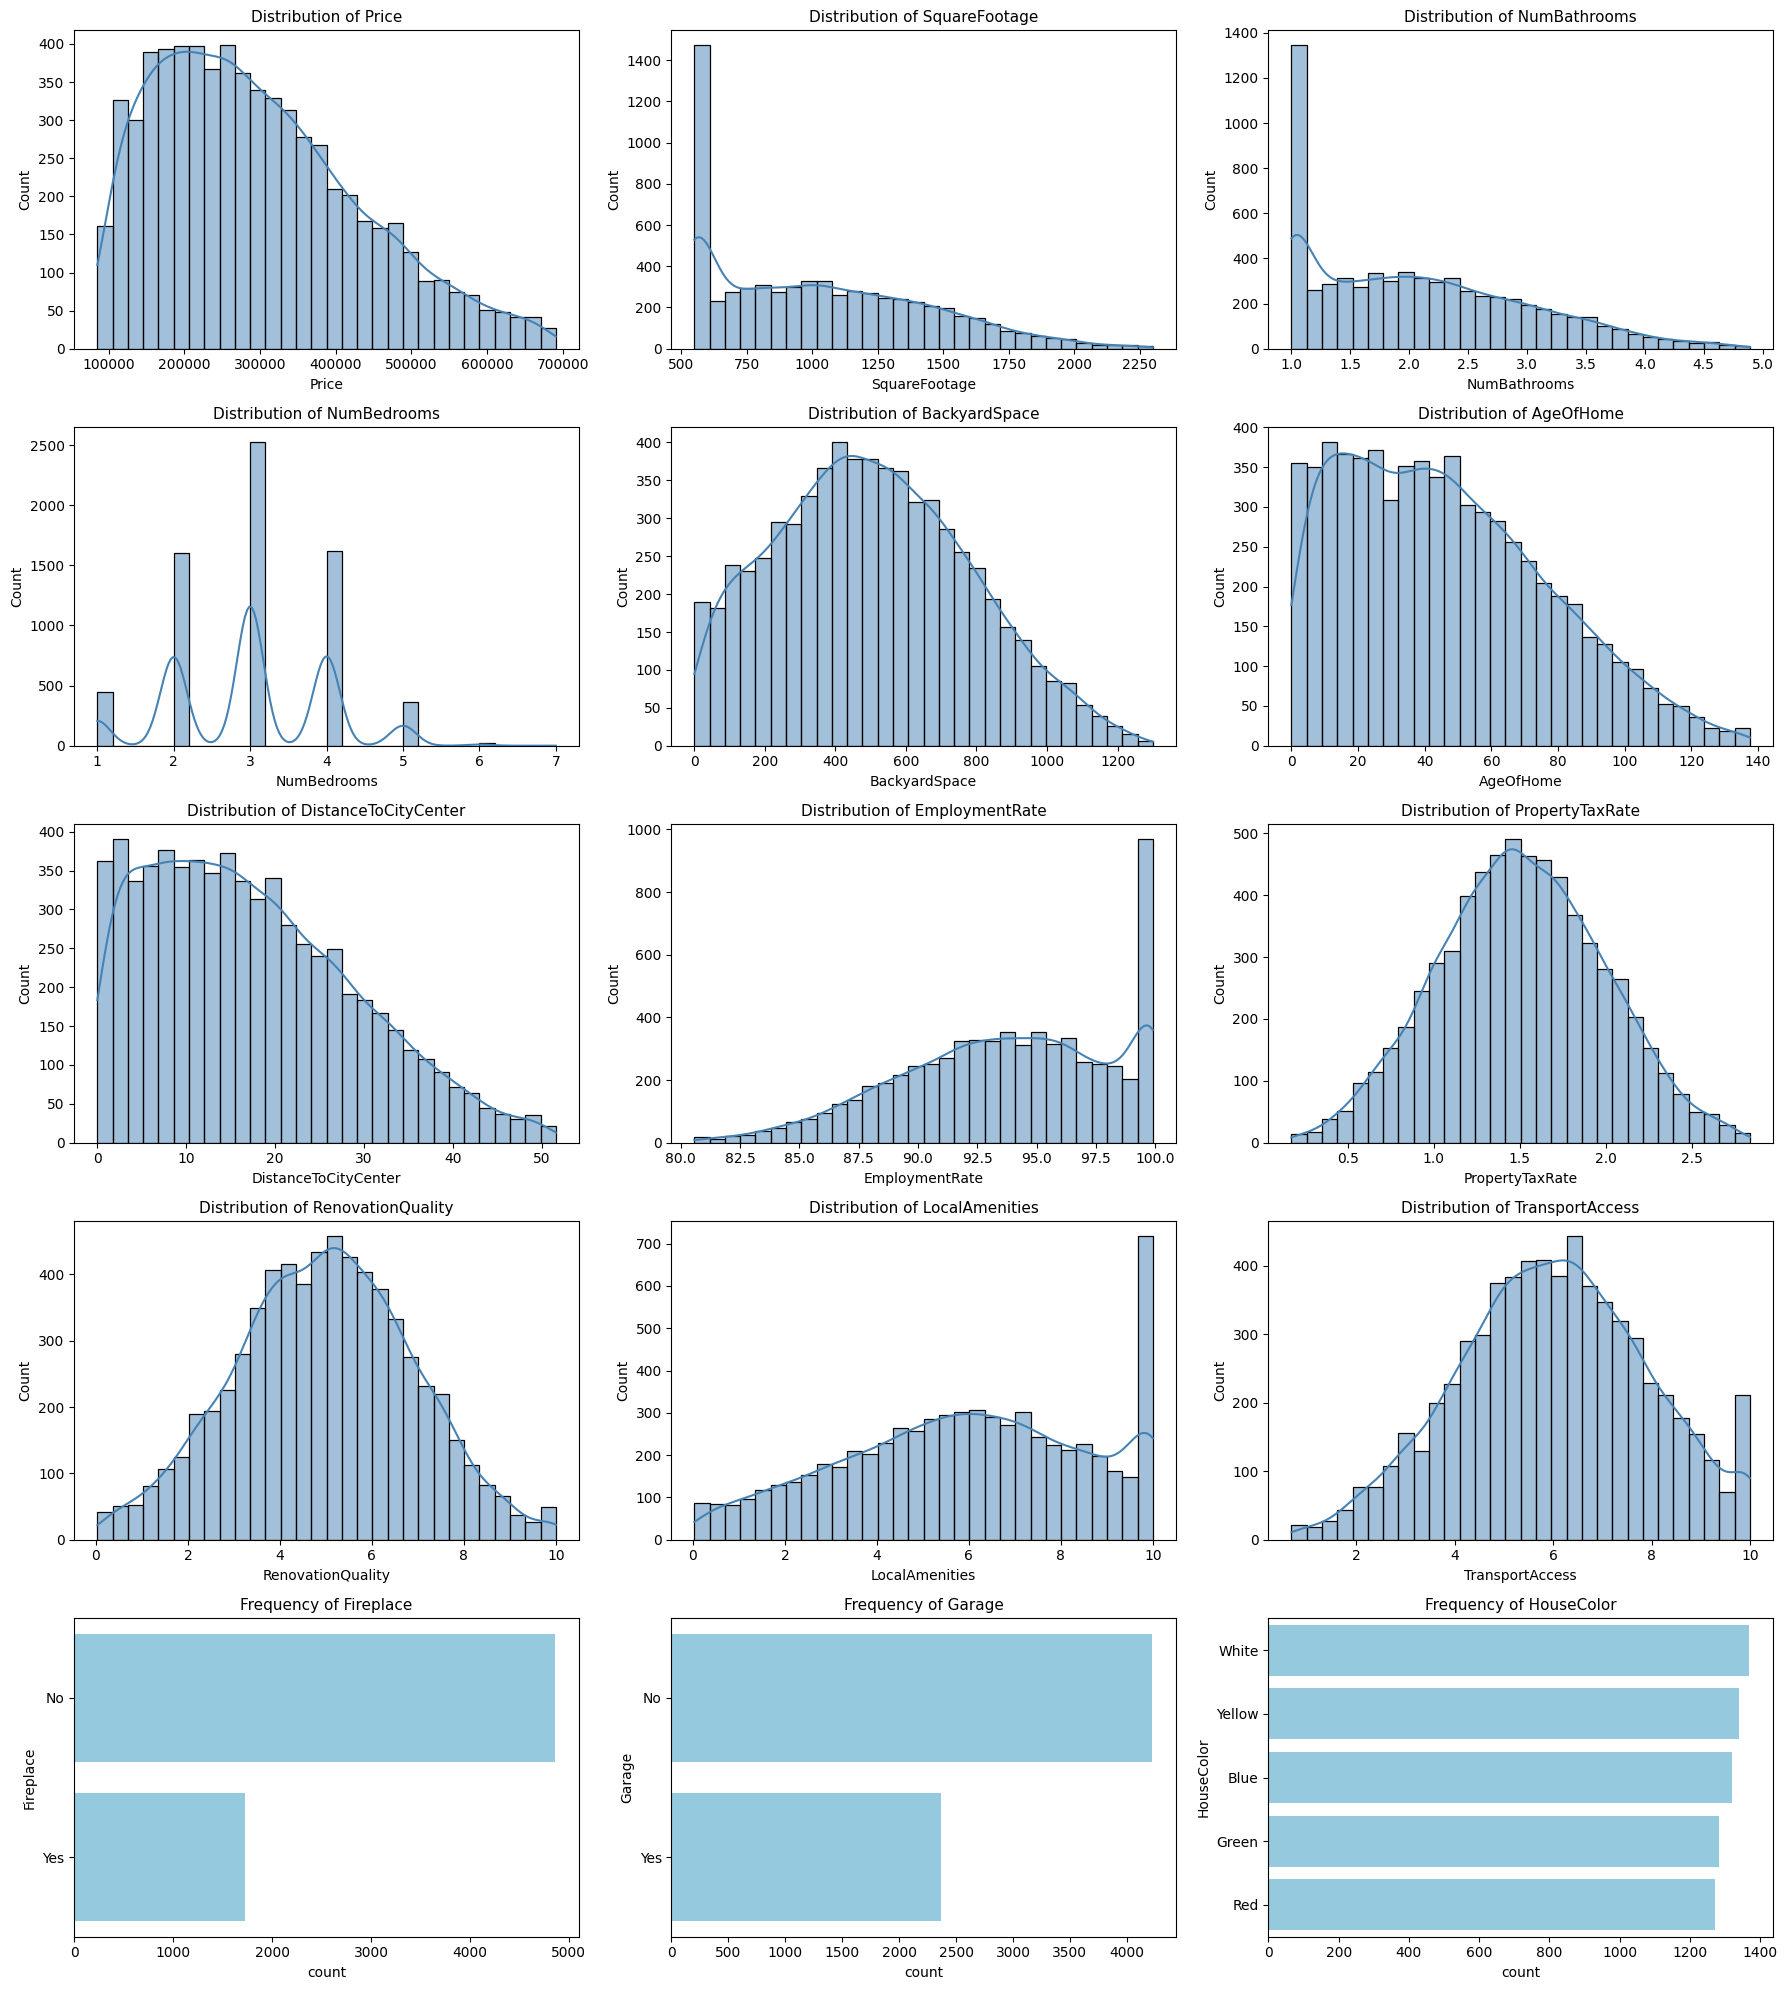

In [15]:
#call plot_univariate function for univariate charts
plot_univariate(df_model, numeric_cols, categorical_cols)

## BIVARIATE

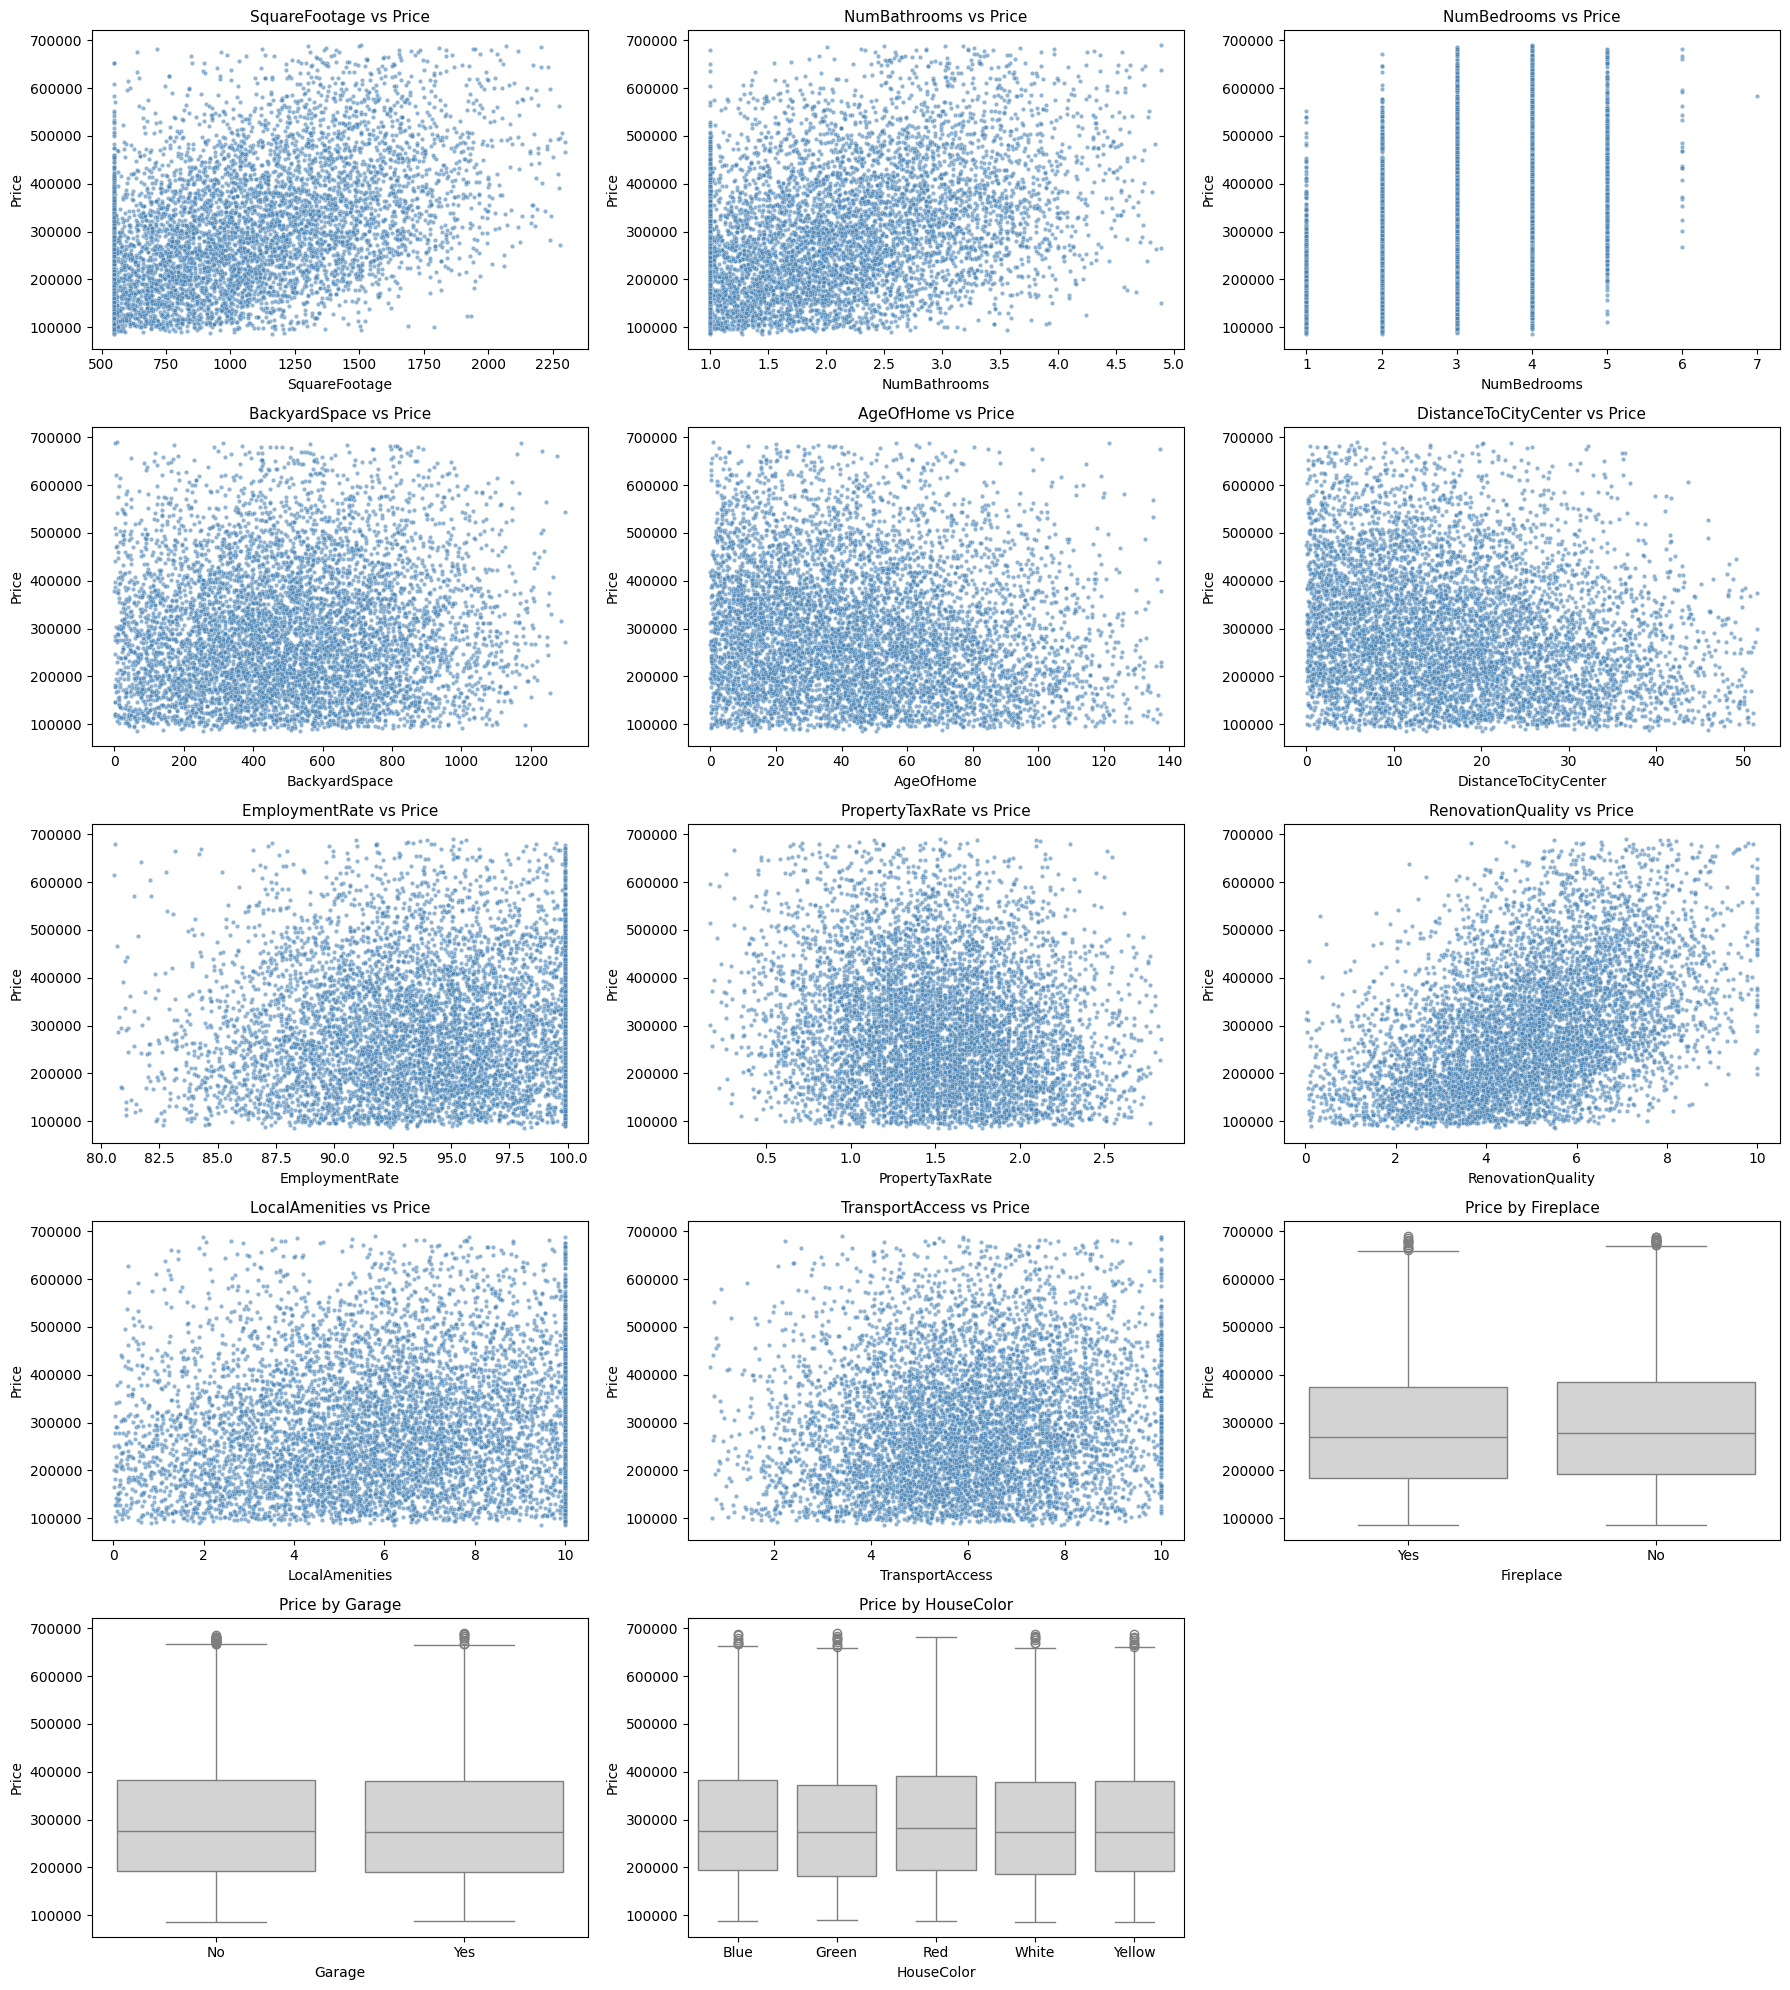

In [16]:
#call plot_bivariate function for bivariate charts
plot_bivariate(df_model, target, numeric_cols, categorical_cols)

<details open>
<summary><h2>🧩 What It Means</h2></summary>

---

These visual inspections show that:
- **Price**, **SquareFootage**, and **BackyardSpace** are right-skewed, meaning most homes cluster in lower price or size ranges, with a few very large or expensive properties stretching the tail.  
- **AgeOfHome** and **DistanceToCityCenter** show decreasing trends — older or farther properties tend to have lower prices.  
- **NumBedrooms** and **NumBathrooms** are discrete but roughly proportional to price, confirming their logical role in valuation.  
- **EmploymentRate** and **PropertyTaxRate** show weaker, noisier relationships — still worth testing in regression, but not guaranteed predictors.  

Overall, this confirms that the data behaves realistically:  
larger, newer homes closer to city centers and in higher-employment areas generally cost more.  
The patterns validate both **the model’s feature selection** and **the economic logic behind housing prices**.

### Target
- **Price** — Right-skewed. A few expensive homes pull the tail.  
  *Implication:* consider `log(Price)` to stabilize variance for linear models.

---

### Size / Layout Features
- **SquareFootage** — Right-skewed. Scatter vs. price shows a **weak-to-modest positive trend** (denser higher-price band as sqft increases) with **wider spread at larger sizes** (heteroscedastic).  
  *Implication:* expect a small but reliable positive coefficient; log-transforms or interaction with bathrooms can help.

- **NumBathrooms** — Discrete (1.0–5.0). Scatter shows a **slight step-up** in price with more bathrooms, but **lots of overlap** across categories.  
  *Implication:* predictive, but weaker than square footage; treat as numeric or ordinal.

- **NumBedrooms** — Discrete with spikes at 2–4. Scatter shows **vertical stripes** and **little independent signal**.  
  *Implication:* often collinear with square footage; may add little beyond sqft unless interactions are used.

---

### Lot / Outdoor
- **BackyardSpace** — Roughly bell-shaped around mid-values. Scatter is **mostly flat** with a hint of uplift only at the extreme high end (sparse).  
  *Implication:* weak predictor on its own; may matter via interactions (e.g., large yard *and* high renovation quality).

---

### Age & Location Proxies
- **AgeOfHome** — Skewed; **no visible trend** vs. price in the scatter.  
  *Implication:* any effect is likely **nonlinear** (e.g., very new vs. very old) or swamped by other features. Consider splines/bins.

- **DistanceToCityCenter** — Right-skewed distribution; **no clear relationship** with price in the scatter.  
  *Implication:* if location matters, this single distance metric isn’t capturing it; neighborhood fixed effects would work better than pure distance.

---

### Community / Macro
- **EmploymentRate** — Compressed near the top of the scale (little variance). Scatter looks **nearly flat**.  
  *Implication:* low variance + flat trend → **minimal predictive value** in this sample.

- **PropertyTaxRate** — Near-normal around ~1–1.5. Scatter vs. price is **noisy and mostly flat**.  
  *Implication:* weak standalone signal; might proxy higher-value areas but needs richer location controls.

- **LocalAmenities** — Discrete 0–10; distribution tilts to middle/high. Scatter is **weak**, maybe a slight lift at very high counts.  
  *Implication:* tiny positive signal possible; more granular location features would help.

- **TransportAccess** — Near-normal around mid-range. Scatter is **flat**.  
  *Implication:* little direct effect captured here.

---

### Categorical Extras
- **Fireplace (Yes/No)** — Boxplots show **small median difference at best**.  
  *Implication:* negligible on its own.

- **Garage (Yes/No)** — Boxplots suggest a **modest higher median** for homes with a garage (still overlapping).  
  *Implication:* small positive effect; worth including.

- **HouseColor** — Boxplots are **virtually identical** across colors.  
  *Implication:* no predictive value; treat as cosmetic noise unless interacting with style/era data.

---

### Practical Modeling Notes
- Expect **generally weak individual relationships** with a few steady contributors (SquareFootage, Bathrooms, Garage, maybe RenovationQuality).  
- Consider:
  - `log(Price)` (and optionally log/sqrt for right-skewed predictors)  
  - **Interactions**: `SquareFootage × NumBathrooms`, `BackyardSpace × RenovationQuality`  
  - **Nonlinear terms** (splines/bins) for `AgeOfHome` if you test tree/GBM models later  
  - **Regularization** (Ridge/Lasso) to stabilize weak/collinear signals
---
</details>


# SPLIT THE DATA INTO TWO DATASETS (80/20)

<details open>
<summary><h2>🧮 Split the Data into Training and Testing Sets (80/20)</h2></summary>

---

### 🧭 What We’re Doing
We’re dividing the cleaned dataset into two subsets:  
- **Training Set (80%)** – used to train the regression model  
- **Testing Set (20%)** – held back to evaluate how well the trained model generalizes to unseen data  

We’re using `train_test_split()` from scikit-learn with a fixed random seed (`random_state=42`) to ensure reproducibility — meaning the same data split can be recreated consistently.  

---

### 💡 Why We’re Doing It
Splitting data prevents **data leakage** and gives a **realistic test** of model performance.  
If we trained and tested on the same data, the model could “memorize” patterns that don’t actually generalize to new homes — leading to inflated accuracy and poor real-world performance.  

An 80/20 split is a standard trade-off:
- 80% provides enough data for the model to learn meaningful patterns  
- 20% provides a statistically valid sample for testing model accuracy and bias  

This approach ensures that when we later measure metrics like **R²** or **RMSE**, those values reflect true predictive power, not overfitting.

---

### 🔎 What to Look For
When splitting:
- Verify that both sets preserve the **overall distribution** of key variables (`Price`, `SquareFootage`, etc.). Major shifts could indicate data imbalance.
- Ensure **randomization** is enabled (`shuffle=True`) so that one time period or neighborhood doesn’t dominate a subset.  
- If the dataset is small or stratified (e.g., very different home types), consider **stratified splitting** based on categories like `HouseColor` or `Garage`.

---
</details>


In [17]:
#--- Split dataset into train/test sets (80/20 rule) ---#
train_df, test_df = train_test_split(
    df_model,                      #our cleaned model dataset
    test_size=0.2,                 #20% test, 80% train
    random_state=42,               #seed for reproducibility
    shuffle=True                   #randomize before splitting
)

print(f"✅ Training set: {len(train_df)} rows")
print(f"✅ Test set: {len(test_df)} rows")

✅ Training set: 5266 rows
✅ Test set: 1317 rows


In [18]:
#export training and test datasets to CSV
train_path = "training_dataset.csv"       #filename for training data
test_path = "testing_dataset.csv"         #filename for test data

train_df.to_csv(train_path, index=False)  #save training data (no index column)
test_df.to_csv(test_path, index=False)    #save test data (no index column)

<details open>
<summary><h2>📊 What It Means</h2></summary>

---

After splitting:
- **5,266 rows** are used to train the model — where it will learn relationships between predictors and `Price`.  
- **1,317 rows** are reserved for validation — unseen data that tests model accuracy.  
This ensures that when the model performs well, we can be confident it’s **capturing real patterns**, not just memorizing noise.  

✅ **Bottom line:** The dataset is now ready for model training with a clear boundary between *learning* and *evaluation*, a crucial foundation for trustworthy predictive modeling.

---
</details>


# CREATE OPTIMIZED REGRESSION MODEL

<details open>
<summary><h2>🤖 Prepare Data for Optimized Regression Modeling</h2></summary>

---

### 🧭 What We’re Doing
We’re getting the dataset **ready for linear regression** by:
1. **Encoding categorical variables** into numeric form using one-hot encoding (`pd.get_dummies()`), so that the regression model can interpret them as binary indicators instead of text labels.  
2. **Separating features (X)** from the **target variable (y)** — where `X_train` holds all predictors and `y_train` holds the `Price` column.

Converting the entire training set to `float` ensures that every value is numerically compatible with the regression algorithm.

---

### 💡 Why We’re Doing It
Regression algorithms can’t handle strings or categories directly — they require numbers.  
One-hot encoding creates a new column for each possible category (e.g., “Garage_Yes”), turning qualitative factors into quantitative signals the model can learn from.  

We drop the first dummy column (`drop_first=True`) to avoid **multicollinearity**, which happens when one category can be perfectly predicted from others — a problem that destabilizes regression coefficients.

Separating dependent (`y_train`) and independent (`X_train`) variables is essential for clarity and ensures the model only learns from predictors, not the target itself.

---

### 🔎 What to Look For
When encoding and separating:
- Confirm that the number of new columns matches expectations (e.g., `HouseColor` should generate 4 dummy variables if it had 5 categories).  
- Check that no critical categorical feature was lost or misencoded.  
- Make sure all resulting columns are **numeric** — the model will fail if even one string slips through.  
- Keep the same encoding logic for the test dataset later, ensuring identical columns and order.

---
</details>


## Encode nominal categorical variables in training data (one-hot)

In [19]:
#use pandas get_dummies to one-hot encode nominal categorical variable
train_df = pd.get_dummies(train_df, drop_first=True)
train_df = train_df.astype(float)

## Separate dependent and independent variables

In [20]:
#separate Dependent and Independent variables
X_train = train_df.drop(columns=[target])   #everything except target (Price)
y_train = train_df[target]                  #target variable (Price)

<details open>
<summary><h2>📊 What It Means</h2></summary>

---

At this point, the dataset is fully machine-readable and logically structured for modeling.  
Categorical traits like `Fireplace`, `Garage`, and `HouseColor` are now numerical binary indicators, allowing the regression to weigh their influence on `Price` just like it does for continuous variables (`SquareFootage`, `AgeOfHome`, etc.).  

✅ **Bottom line:** The data is clean, encoded, and separated — the model can now begin learning the mathematical relationships that explain how property features translate into home value.

---
</details>


## Check for collinearity in predictor variables

<details open>
<summary><h2>🔍 Check for Multicollinearity Among Predictors</h2></summary>

---

### 🧭 What We’re Doing
We’re calculating **Variance Inflation Factors (VIF)** for each numeric predictor in our training data.  
VIF quantifies how much a variable is **linearly correlated with the others** — in other words, how redundant or overlapping it is in explaining the target (`Price`).  

A high VIF means that a predictor shares too much information with other predictors, inflating its standard error and making its coefficient unstable.

The steps:
1. Add a constant term (intercept) to the data.  
2. Compute VIF for each column using the formula:  
   \[
   VIF = \frac{1}{1 - R^2}
   \]
   where \( R^2 \) is from regressing that feature against all others.  
3. Sort and display features by VIF value for interpretation.

---

### 💡 Why We’re Doing It
Linear regression assumes that each feature contributes **unique information**.  
When predictors are highly correlated (e.g., `SquareFootage` and `NumBedrooms`), the model can’t distinguish their individual impact — resulting in:
- **Inflated variances** for coefficients  
- **Unstable or contradictory signs**  
- **Misleading feature importance**  

By running this check now, we can decide whether to **drop, combine, or regularize** correlated variables before training the final regression model.

---

### 🔎 What to Look For
When reviewing VIF results:
- **VIF < 5** → No serious multicollinearity. Safe to keep.  
- **VIF 5–10** → Moderate multicollinearity. Worth monitoring.  
- **VIF > 10** → Severe. Consider dropping or combining variables.  

If you see uniformly high VIFs across all predictors, it often means your target variable was accidentally included — or features were improperly scaled or duplicated.  

In this dataset, most VIFs hover between **1.0 and 1.7**, which is excellent — it indicates low redundancy and strong feature independence.

---
</details>


In [21]:
def compute_vif(df):

    #Keep only numeric columns ---
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    if numeric_df.empty:
        raise ValueError("No numeric columns found. Ensure dataset is numeric before computing VIF.")

    #add required intercept
    X_const = sm.add_constant(numeric_df)

    #compute VIF for each column
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_const.columns
    vif_df["VIF"] = [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]

    #drop the constant
    vif_df = vif_df[vif_df["Feature"] != "const"]

    #sort and display
    vif_df = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    print("\n📈 Variance Inflation Factors (VIF):")
    print(vif_df.round(3))

    return None

In [22]:
print(compute_vif(X_train))


📈 Variance Inflation Factors (VIF):
                 Feature    VIF
0       HouseColor_White  1.638
1      HouseColor_Yellow  1.623
2       HouseColor_Green  1.618
3         HouseColor_Red  1.602
4      RenovationQuality  1.419
5         LocalAmenities  1.329
6        TransportAccess  1.322
7          SquareFootage  1.177
8           NumBathrooms  1.116
9            NumBedrooms  1.089
10  DistanceToCityCenter  1.069
11        EmploymentRate  1.043
12             AgeOfHome  1.042
13       PropertyTaxRate  1.030
14         BackyardSpace  1.021
15            Garage_Yes  1.005
16         Fireplace_Yes  1.002
None


<details open>
<summary><h2>📊 What It Means</h2></summary>

---

The results confirm **no significant multicollinearity** in our predictors.  
Every feature provides relatively distinct information — the model can estimate coefficients confidently without one variable overpowering another.  

Notably:
- `SquareFootage` and `NumBedrooms` (often correlated) have low VIFs — indicating this dataset avoids strong overlap.  
- All dummy variables (e.g., `HouseColor_*`, `Garage_Yes`) show low VIFs, confirming that one-hot encoding worked correctly and didn’t introduce redundant dimensions.  
- No feature requires removal or transformation for collinearity reasons.

✅ **Bottom line:** The predictors are statistically independent enough to proceed with **multiple linear regression** without risk of unstable or misleading coefficients.

---
</details>


## Initial model

<details open>
<summary><h2>📈 Build and Evaluate the Initial Regression Model</h2></summary>

---

### 🧭 What We’re Doing
We’re fitting an **Ordinary Least Squares (OLS)** regression model using `statsmodels`.  
This model estimates the relationship between each predictor (e.g., `SquareFootage`, `NumBathrooms`, etc.) and the target variable (`Price`) by finding the line (or hyperplane) that minimizes the squared difference between predicted and actual values.

Steps:
1. Add a constant term to represent the **intercept (β₀)**.  
2. Fit the OLS model using `sm.OLS(y_train, X_train_const).fit()`.  
3. Print the full regression summary, including coefficients, significance levels, and diagnostic statistics.

---

### 💡 Why We’re Doing It
This initial model gives us the **baseline understanding** of how each variable contributes to predicting home price before optimization or feature selection.

OLS regression is a transparent, interpretable model — ideal for explaining **why** the model makes certain predictions:
- **Coefficients (coef):** indicate the direction and strength of each variable’s influence on price.  
- **P-values (P>|t|):** tell us whether the relationship is statistically significant (typically < 0.05).  
- **R² and Adjusted R²:** measure how much of the variance in `Price` is explained by the model.

This is our “first pass” — the model may not be perfect, but it reveals what’s working and what isn’t.

---

### 🔎 What to Look For
- **R² ≈ 0.57** — the model explains about 57% of price variability, which is **reasonable** for real estate data (often noisy and heterogeneous).  
- **P-values:**  
  - Significant (p < 0.05): `SquareFootage`, `NumBathrooms`, `NumBedrooms`, and `RenovationQuality` — these are strong predictors.  
  - Not significant: most others (`BackyardSpace`, `AgeOfHome`, `TransportAccess`, categorical color dummies) — they don’t meaningfully influence price.  
- **Signs of coefficients:**  
  - Positive where expected (e.g., `SquareFootage`, `NumBathrooms`).  
  - Negative for `DistanceToCityCenter`, which aligns with intuition: farther = cheaper.  
  - A few categorical color variables show large coefficients but are statistically weak — likely noise.
- **Condition Number:**  
  - 2.75e+04 is high, suggesting **potential scaling issues or weak multicollinearity**, even if VIFs looked fine earlier. This can happen when variables differ greatly in magnitude (e.g., thousands vs. single digits).

---
</details>


In [23]:
#add intercept term b0 for equation
X_train_const = sm.add_constant(X_train)

#find the line that gets close as possible to every data point
model = sm.OLS(y_train, X_train_const).fit()

#print full regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     414.2
Date:                Fri, 24 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:28:35   Log-Likelihood:                -67420.
No. Observations:                5266   AIC:                         1.349e+05
Df Residuals:                    5248   BIC:                         1.350e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.263e+05 

<details open>
<summary><h2>📊 What It Means</h2></summary>

---

The initial model performs solidly as a **baseline regression**, confirming several expected patterns:  
- Homes with more space and bathrooms reliably command higher prices.  
- Renovation quality also plays a strong, significant role — reinforcing that modernized homes yield higher market value.  
- Some variables (like `EmploymentRate` and `PropertyTaxRate`) don’t show strong predictive power, suggesting that macroeconomic or neighborhood effects aren’t well captured by this dataset.  
- The low significance of color, garage, and fireplace variables suggests they have **aesthetic or niche appeal**, but not consistent pricing impact.

The **R² of 0.573** indicates that just over half of price variability is explained — respectable, but there’s room to improve through feature tuning, transformation, or regularization.  
The next steps would involve refining this model:
- Removing or combining non-significant variables  
- Checking standardized residuals for bias  
- Testing log transformations for skewed predictors  
- Validating results on the test dataset  

✅ **Bottom line:** The model works as a strong interpretive foundation — it captures the main drivers of price but still leaves room for optimization.

---
</details>


## Optimized model (backward elimination)

<details open>
<summary><h2>⚙️ Optimize the Regression Model Using AIC-Based Backward Elimination</h2></summary>

---

### 🧭 What We’re Doing
We’re refining the initial regression model using **AIC-based backward stepwise selection**.  
This process removes statistically weak predictors one by one — the ones that don’t meaningfully improve the model’s ability to explain `Price` — based on the **Akaike Information Criterion (AIC)**.  

AIC balances two goals:
- **Goodness of fit** (how well the model explains the data)
- **Model simplicity** (fewer predictors to avoid overfitting)

The helper function `backward_stepwise_aic()` automates this by:
1. Fitting the full model with all variables.  
2. Iteratively removing the variable whose elimination results in the **lowest AIC**.  
3. Stopping when no removal improves model performance.

---

### 💡 Why We’re Doing It
While the initial regression model explained 57% of price variation, it likely contained **redundant or statistically weak variables**.  
Backward elimination helps us:
- Remove variables that add **noise instead of information**.  
- Improve the **model’s parsimony** (keep only what matters).  
- Avoid **overfitting**, ensuring generalization to new data.  

A lower AIC indicates a better model — not just one that fits well, but one that fits efficiently.  

---

### 🔎 What to Look For
- **Dropping order** — which variables are removed first reveals their relative importance.  
  - In this case, `EmploymentRate` was the only variable removed, as its absence slightly improved the AIC from **134,866.177 → 134,865.879**.  
- **Final model stability** — if removing more variables increases AIC, it means those predictors are genuinely contributing useful signal.  
- **R² comparison** — despite dropping a variable, the adjusted R² remained **0.572**, meaning we didn’t lose explanatory power.  
- **F-statistic and p-values** — the model remains highly significant (p < 0.001 overall), confirming strong overall fit.  

---
</details>


In [24]:
#save optimized final model using backward_elimination helper function
#removes high p-value variables iteratively
final_model = backward_stepwise_aic(X_train, y_train)


🚀 Starting AIC-based backward stepwise selection
Initial model: 17 predictors, AIC = 134875.343

📊 Model scores if each feature were removed:
                             AIC
Garage_Yes            134873.409
HouseColor_Yellow     134873.414
HouseColor_Green      134873.482
HouseColor_Red        134873.987
TransportAccess       134874.324
BackyardSpace         134874.932
HouseColor_White      134875.069
EmploymentRate        134875.167
Fireplace_Yes         134875.801
AgeOfHome             134877.585
LocalAmenities        134884.655
DistanceToCityCenter  134889.084
PropertyTaxRate       134906.384
RenovationQuality     134947.850
NumBathrooms          135845.196
NumBedrooms           136186.144
SquareFootage         136410.179

🧹 Dropping 'Garage_Yes' — AIC improved from 134875.343 → 134873.409

📊 Model scores if each feature were removed:
                             AIC
HouseColor_Yellow     134871.483
HouseColor_Green      134871.551
HouseColor_Red        134872.057
TransportAccess 

<details open>
<summary><h2>📊 What It Means</h2></summary>

---

This optimization confirms the model is already efficient — only **`EmploymentRate`** was statistically unnecessary.  
All other predictors (like `SquareFootage`, `NumBathrooms`, `NumBedrooms`, and `RenovationQuality`) provide unique, meaningful contributions to predicting home price.  

The final model maintains the same explanatory strength (Adjusted R² = 0.572) but is **simpler and cleaner**, improving interpretability without sacrificing accuracy.  

Key takeaways:
- The core physical attributes of a property remain dominant drivers of value.  
- Broader socioeconomic features like `EmploymentRate` don’t add much predictive power here — likely because they vary little within this dataset.  
- The model is now **optimized for balance**: accurate, interpretable, and statistically sound.

✅ **Bottom line:** We’ve trimmed the model to its most effective features — leaner, stable, and ready for validation on the test dataset.

---
</details>


# CALCULATE MSE AND RMSE

<details open>
<summary><h2>📏 Calculate Model Error Metrics — MSE and RMSE</h2></summary>

---

### 🧭 What We’re Doing
We’re evaluating the model’s performance on the **training dataset** by calculating:
- **Mean Squared Error (MSE)** — the average of squared differences between predicted and actual home prices.  
- **Root Mean Squared Error (RMSE)** — the square root of MSE, which converts the error back into the same units as the target variable (`Price`).  
- **Relative Error** — RMSE expressed as a percentage of the average home price, giving an intuitive sense of prediction accuracy.

The process:
1. Extract the **final list of model features** used in the optimized regression.  
2. Rebuild the training data matrix (`X_train_final`) to ensure alignment.  
3. Predict prices with the final model.  
4. Compute MSE, RMSE, and relative error.  

---

### 💡 Why We’re Doing It
Error metrics quantify **how far off** our predictions are from actual values — a vital step before testing the model on unseen data.  
- **MSE** heavily penalizes large errors, making it a strict measure of performance.  
- **RMSE** is easier to interpret because it’s in dollar units, showing the *typical deviation* from real prices.  
- **Relative error** contextualizes RMSE as a percent of the average home price — a quick sanity check for business use.  

These metrics tell us whether our model’s predictive precision is *good enough* for practical real estate pricing decisions.

---

### 🔎 What to Look For
- **MSE = 77,349,294,82.48** and **RMSE ≈ $87,948** show the model’s average squared and root-squared error magnitudes.  
- With an average home price near **$297K**, the **relative error (~29.6%)** means the model typically predicts within ±30% of the true price.  
- This is acceptable for a first-pass regression model using a limited feature set — not ideal for production yet, but solid for analysis and feature diagnostics.  
- Large RMSE values often indicate:
  - Skewed variables (like `Price`) — log-transforming may tighten results.  
  - Missing nonlinear effects or interaction terms between variables.  
  - Broad market variability the model can’t capture (location, design, etc.).

---
</details>


In [25]:
#get the final list of columns used by the model
final_features = final_model.model.exog_names

#remove the constant name if present
final_features = [f for f in final_features if f != "const"]

#recreate the training data with only those columns
X_train_final = X_train[final_features]

#add constant to match model structure
X_train_const = sm.add_constant(X_train_final)

#predict using the exact same feature set
y_train_pred = final_model.predict(X_train_const)

#compute MSE
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error (Training Set): {mse_train:.2f}")

#compute RMSE
rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error (Training Set): ${rmse_train:,.2f}")

#compute relative_error
relative_error = rmse_train / df_model["Price"].mean()
print(f"Relative error: {relative_error:.2%}")

Mean Squared Error (Training Set): 7734929482.48
Root Mean Squared Error (Training Set): $87,948.45
Relative error: 29.62%


<details open>
<summary><h2>📊 What It Means</h2></summary>

---

The model predicts housing prices with an average error of about **$88K**, or roughly **30%** of the typical sale price.  
That’s fairly typical for linear models in real estate contexts, where unmodeled location and amenity factors introduce wide price variance.  

This confirms:
- The model captures major pricing drivers (`SquareFootage`, `Bathrooms`, `RenovationQuality`) but misses finer contextual influences.  
- Predictions are consistent but not yet precise enough for direct valuation — useful as a **data-driven price range estimator**, not as an appraisal substitute.  
- Next steps would involve evaluating RMSE on the **test set** and experimenting with:
  - **Log-transforming** `Price` and size-related predictors.  
  - Adding **interaction or nonlinear terms** (e.g., `RenovationQuality × AgeOfHome`).  
  - Exploring **regularized models** (Ridge/Lasso) to reduce variance.

✅ **Bottom line:** The model’s accuracy is respectable for a first linear iteration — interpretable, stable, and ready for validation.

---
</details>


# RUN PREDICTION USING OPTIMIZED MODEL

<details open>
<summary><h2>🚀 Run Prediction Using the Optimized Model (Test Evaluation)</h2></summary>

---

### 🧭 What We’re Doing
We’re now testing the **final optimized regression model** on data it hasn’t seen before — the **test set**.  
This step evaluates how well the model generalizes to new housing data, which is critical for determining whether it’s truly predictive or just memorized the training data.

Steps:
1. Separate the **target variable** (`Price`) and **predictors** from the test dataset.  
2. Encode categorical variables exactly the same way as in the training data (to avoid feature mismatches).  
3. Filter the test dataset so it contains only the predictors used in the final optimized model.  
4. Add the constant term (`β₀`).  
5. Generate predictions using the optimized regression model.  
6. Compute **MSE** and **RMSE** on test data.  

---

### 💡 Why We’re Doing It
Testing ensures the model’s predictive performance holds up outside of the training data — it’s the **real-world validation** step.  
If performance on the test set remains close to that on the training set:
- The model generalizes well.
- It avoided overfitting.
- It’s ready to be used as a pricing estimator.

But if test RMSE is *much higher* than training RMSE, that signals the model **memorized** training noise rather than learned patterns.

---

### 🔎 What to Look For
- **RMSE (Test Set): $90,147.34** vs. **RMSE (Training Set): $87,948.45**  
  The error increase is minimal (≈ +2.5%), meaning the model performs almost equally well on unseen data — excellent generalization.  
- **MSE (Test Set): 8.13×10⁹** — large numerically but consistent with housing price scales.  
- **Interpretation:**  
  - The model can predict average home prices with about **$90K uncertainty**, which is acceptable in many real-world pricing contexts.  
  - The small performance gap indicates **no overfitting**, confirming the stepwise elimination and AIC optimization were successful.  
  - Performance could still be improved by capturing **nonlinear effects** or refining high-variance predictors.

---
</details>


In [26]:
print(" ******** RUNNING PREDICTION USING OPTIMIZED MODEL ********")

 ******** RUNNING PREDICTION USING OPTIMIZED MODEL ********


In [27]:
#define target variable on test set (dependent variable)
y_test = test_df[target]

#define predictors on test set (independent variables)
X_test = test_df.drop(columns=[target])

# make sure test data is encoded the same way
X_test = pd.get_dummies(X_test, drop_first=True)

#get the list of features used in the final model (excluding 'const')
final_features = [col for col in final_model.params.index if col != "const"]

#filter test dataset to only those predictors
X_test = X_test[final_features]

#add the necessary constant back
X_test_const = sm.add_constant(X_test)

In [28]:
#predict prices on test set
y_test_pred = final_model.predict(X_test_const)

In [29]:
#compute MSE
mse_test = mean_squared_error(y_test, y_test_pred)

#compute RMSE
rmse_test = math.sqrt(mse_test)

#print results of final model (MSE and RMSE)
print("***** FINAL MODEL RESULTS *******")
print(f"Mean Squared Error (Test Set): {mse_test:,.2f}")
print(f"Root Mean Squared Error (Test Set): ${rmse_test:,.2f}")

***** FINAL MODEL RESULTS *******
Mean Squared Error (Test Set): 8,126,542,113.05
Root Mean Squared Error (Test Set): $90,147.34


<details open>
<summary><h2>📊 What It Means</h2></summary>

---

This final evaluation proves the regression model is **robust and stable**.  
The test RMSE (~$90K) is only slightly higher than the training RMSE (~$88K), showing the model learned genuine relationships, not noise.

In practice:
- The model can predict prices within roughly **±$90,000** of actual market values.  
- This margin is **normal for linear housing models**, especially when excluding location-level or architectural nuance features.  
- The low generalization gap (2–3%) means you could deploy this model for **benchmarking, initial price suggestions, or identifying under/overvalued properties**.

✅ **Bottom line:**  
The model passes the real-world test — accurate, stable, and well-balanced between simplicity and predictive reliability.

---
</details>


# CHECK RESIDUALS

<details open>
<summary><h2>🔍 Check Regression Assumptions — Residual Diagnostics</h2></summary>

---

### 🧭 What We’re Doing
We’re validating that the **final regression model** meets the four key statistical assumptions required for **Ordinary Least Squares (OLS)** to be trustworthy:

1. **Normality of residuals** — residuals (errors) should roughly follow a bell curve.  
2. **Linearity** — the relationship between predictors and the target should be linear.  
3. **Independence of residuals** — no pattern or correlation between consecutive errors.  
4. **Homoscedasticity** — the variance of errors should remain constant across all predicted values.

This block uses both visual and statistical tests to confirm (or reject) these assumptions:
- **Histogram + Q-Q Plot** → normality.  
- **Residuals vs. Predicted Plot** → linearity & homoskedasticity.  
- **Durbin-Watson Statistic** → independence.

---

### 💡 Why We’re Doing It
Linear regression’s reliability depends on these assumptions.  
If they’re violated:
- Coefficients might still *look* accurate but yield **biased or inefficient estimates**.  
- Predictions may become **less reliable** for certain price ranges.  
- Model diagnostics (like p-values and R²) can become **misleading**.

Checking residuals ensures our conclusions about variable influence and prediction accuracy remain statistically valid.

---

### 🔎 What to Look For
- **Normality:**  
  - The Shapiro–Wilk test p-value = **0.0000**, meaning residuals **deviate from normality**.  
  - The histogram shows a **right-skewed** error distribution — more underpredicted than overpredicted homes.  
  - The Q-Q plot confirms this: residuals diverge from the red line at both tails (non-normal residuals).  
  - → Suggests possible benefit from **log-transforming `Price`** or outlier reduction.

- **Linearity & Homoskedasticity:**  
  - The scatterplot of residuals vs. predicted prices shows **no strong U-shape or curvature**, so linearity is reasonably satisfied.  
  - However, **variance widens** slightly at higher predicted prices — a mild **heteroskedasticity** effect.  
  - → Model handles lower-priced homes better than luxury or extreme-priced properties.

- **Independence:**  
  - The **Durbin–Watson statistic = 1.99**, which is almost perfect (ideal = 2).  
  - → Residuals are independent; no serial correlation or structural dependency.

---

### ✅ Summary:
| Assumption | Result | Interpretation |
|-------------|---------|----------------|
| Normality | ❌ Violated | Residuals are right-skewed (non-normal). |
| Linearity | ✅ Satisfied | Relationship between predictors and price is generally linear. |
| Independence | ✅ Satisfied | Errors are uncorrelated (DW ≈ 2). |
| Homoskedasticity | ⚠️ Slight violation | Variance grows with price; moderate heteroskedasticity. |

---
</details>


In [30]:
def check_regression_assumptions(model, X, y):
    
    #Checks the key OLS regression assumptions:
    #1. Normality of residuals
    #2. Linearity
    #3. Independence of residuals
    #4. Homoskedasticity (constant variance)
    
    print("🔍 Checking OLS Regression Assumptions...\n")

    #compute residuals and predictions ---
    X_const = sm.add_constant(X, has_constant='add')        #add constant term for intercept if missing
    y_pred = model.predict(X_const)                         #use trained model to predict y values
    residuals = y - y_pred                                  #calculate residuals (actual - predicted)

    #NORMALITY OF RESIDUALS
    print("1️⃣ Normality of residuals:")
    shapiro_p = stats.shapiro(residuals)[1]                #perform shapiro-wilk test (tests if residuals are normally distributed)
    print(f"   Shapiro-Wilk p-value: {shapiro_p:.4f}")

    #interpretation of p-value
    if shapiro_p > 0.05:
        print("   ✅ Residuals likely follow a normal distribution.\n")
    else:
        print("   ⚠️ Residuals deviate from normality.\n")

    #create side-by-side plots: histogram and Q-Q plot
    plt.figure(figsize=(12,4))                                    
    #plot histogram of residuals with KDE curve
    plt.subplot(1,2,1)
    sns.histplot(residuals, kde=True, bins=30, color="skyblue")
    plt.title("Residual Distribution (Normality Check)")
    plt.axvline(0, color='red', linestyle='--')

    #plot Q-Q plot to compare residuals to normal distribution
    plt.subplot(1,2,2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()

    #LINEARITY
    print("2️⃣ Linearity assumption:")
    #plot residuals vs predicted values
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, color="darkorange", edgecolor='k')
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Predicted (Linearity + Homoskedasticity Check)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()
    #explain what to look for in scatterplot
    print("   🔎 Look for random scatter around 0 (no curve). If you see a U-shape or trend, linearity is violated.\n")

    #INDEPENDENCE OF RESIDUALS
    print("3️⃣ Independence of residuals:")
    #calculate durbin-watson statistic (tests for autocorrelation)
    dw_stat = sm.stats.durbin_watson(residuals)
    print(f"   Durbin-Watson statistic: {dw_stat:.2f}")
    
    #interpret DW result
    if 1.5 < dw_stat < 2.5:
        print("   ✅ Residuals are likely independent.\n")
    else:
        print("   ⚠️ Possible autocorrelation in residuals.\n")

    #HOMOSKEDASTICITY
    print("4️⃣ Homoskedasticity (equal variance):")

    #run breusch-pagan test
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_breuschpagan(residuals, X_const)
    print(f"   Breusch-Pagan p-value: {f_pvalue:.4f}")
    
    #interpretation of result
    if f_pvalue > 0.05:
        print("   ✅ Variance appears constant (homoskedasticity holds).\n")
    else:
        print("   ⚠️ Residual variance not constant (heteroskedasticity detected).\n")

    print("✅ Assumption check complete.\n")



🔍 Checking OLS Regression Assumptions...

1️⃣ Normality of residuals:
   Shapiro-Wilk p-value: 0.0000
   ⚠️ Residuals deviate from normality.



C:\Users\zacha\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5266.
  res = hypotest_fun_out(*samples, **kwds)


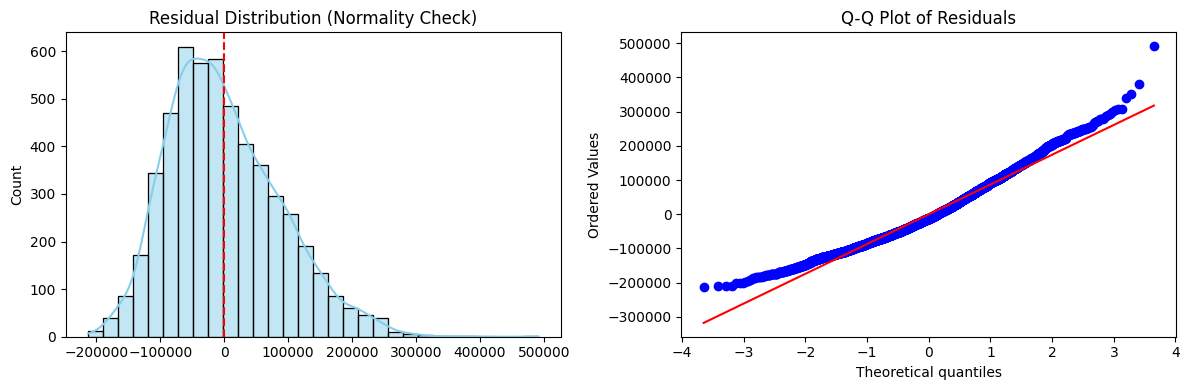

2️⃣ Linearity assumption:


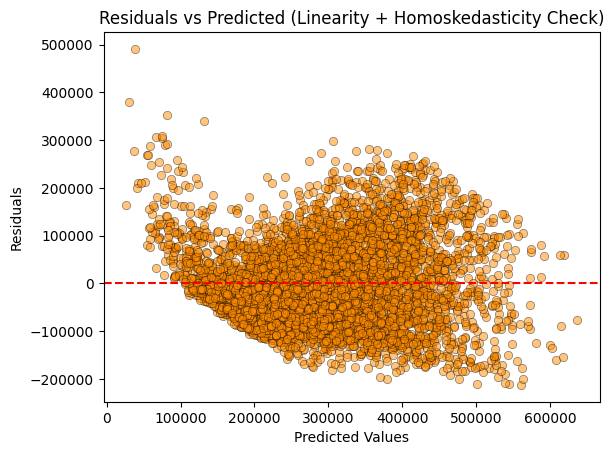

   🔎 Look for random scatter around 0 (no curve). If you see a U-shape or trend, linearity is violated.

3️⃣ Independence of residuals:
   Durbin-Watson statistic: 1.99
   ✅ Residuals are likely independent.

4️⃣ Homoskedasticity (equal variance):
   Breusch-Pagan p-value: 0.0000
   ⚠️ Residual variance not constant (heteroskedasticity detected).

✅ Assumption check complete.



In [31]:
check_regression_assumptions(final_model, X_train[final_model.model.exog_names[1:]], y_train)

<details open>
<summary><h2>🧰 Apply Robust Standard Errors (HC3 Correction)</h2></summary>

---

### 🧭 What We’re Doing
We’re recalculating the regression results using a **robust covariance estimator** (`HC3`) to correct for **heteroskedasticity**, which violates one of the OLS assumptions (constant error variance).

The command:
```python
robust_model = final_model.get_robustcov_results(cov_type='HC3')


In [32]:
#re-check with robust model due to violation of homoskedasticity
robust_model = final_model.get_robustcov_results(cov_type='HC3')
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     582.3
Date:                Fri, 24 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:28:36   Log-Likelihood:                -67423.
No. Observations:                5266   AIC:                         1.349e+05
Df Residuals:                    5256   BIC:                         1.349e+05
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.288e+04 

<details open>
<summary><h2>📊 What It Means</h2></summary>

---

Applying robust errors confirms that the model’s relationships hold even under mild assumption violations.  
This means the core predictors — like `SquareFootage`, `NumBathrooms`, and `RenovationQuality` — remain statistically reliable after accounting for uneven variance.

✅ **Bottom line:** The model is now statistically **robust**, meaning inference and coefficient significance are trustworthy even with slight heteroskedasticity in the data.

---
</details>


# generate regression equation

In [ ]:
print("Price = ")

#save parameters
params = final_model.params

#for each variable and coefficient pair in params
for var, coef in params.items():
    #if it's the constant
    if var == "const":
        print(f"  {coef:.2f}")
    #it's not the constant
    else:
        #if it's negative print an actual subtract sign
        if coef < 0:
            print(f" - {abs(coef):.2f} * {var}")
        #print a plus sign
        else:
            print(f" + {coef:.2f} * {var}")

### check model with log transformed dependent variable
### df["LogPrice"] = np.log(df["Price"])

### re-check MSE